# Description: Classification tutorial using DenseNet



In [17]:
class MyConfig:
    def __init__(self):
        # Transform
        self.p_blur = 0.5 # ぼかしを入れる確率

        # condition
        self.batch_size = 16
        self.lr = 5e-6
        self.device = "cuda"
        self.num_epochs = 100

        # Data
        self.val_ratio = 0.2

        # DenseNet-121
        self.growth_rate=32
        self.block_config=(6, 12, 24, 16)

## モジュールインポート

In [20]:
config = MyConfig()

## データの読み込み

In [3]:
# インポート
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import random
import matplotlib.pyplot as plt

In [4]:
class RandomBlur(torch.nn.Module):
    def __init__(self, p=config.p_blur):
        super().__init__()
        self.p = p
        self.blur = transforms.GaussianBlur(kernel_size=3)
    def __call__(self, img):
        if torch.rand(1) < self.p: # True
            return self.blur(img)
        return img # False

### MNIST

In [5]:
# # Transform
# train_transform = transforms.Compose([
#     transforms.ToTensor(),        # テンソルに変換 & 0-255 の値を 0-1 に変換
#     transforms.Normalize(mean=[0.445], std=[0.269]),  # 正規化
#     RandomBlur(), # Random Blur
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),        # テンソルに変換 & 0-255 の値を 0-1 に変換
#     transforms.Normalize(mean=[0.445], std=[0.269]),  # 正規化
# ])

In [6]:
# # MNIST を取得
# # Train
# train_dataset = datasets.MNIST(
#     root='data',          # データを保存するディレクトリ
#     train=True,           # 学習用データを取得
#     download=True,        # データがない場合はダウンロードする
#     transform=train_transform,  # 画像データの変換方法を指定
# )

# # Validation
# val_dataset = datasets.MNIST(
#     root='data',
#     train=True,
#     download=True,
#     transform=test_transform,
# )

# # test
# test_dataset = datasets.MNIST(
#     root='data',
#     train=False,
#     download=True,
#     transform=test_transform,
# )

### CIFAR-10

In [7]:
# Transform
train_transform = transforms.Compose([
    transforms.ToTensor(),        # テンソルに変換 & 0-255 の値を 0-1 に変換
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),  # 正規化
    RandomBlur(), # Random Blur
    transforms.RandomHorizontalFlip(p=0.5),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),        # テンソルに変換 & 0-255 の値を 0-1 に変換
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),  # 正規化
])

In [8]:
# CIFAR-10 を取得
# Train
train_dataset = datasets.CIFAR10(
    root='data',          # データを保存するディレクトリ
    train=True,           # 学習用データを取得
    download=True,        # データがない場合はダウンロードする
    transform=train_transform,  # 画像データの変換方法を指定
)

# Validation
val_dataset = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=test_transform,
)

# test
test_dataset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=test_transform,
)

100%|██████████| 170M/170M [00:05<00:00, 28.6MB/s]


In [9]:
'''
データセットを分割するための2つの排反なインデックス集合を生成する関数
dataset    : 分割対象のデータセット
ratio      : 1つ目のセットに含めるデータ量の割合
random_seed: 分割結果を不変にするためのシード
'''
def generate_subset(dataset: Dataset, ratio: float,
                    random_seed: int=0):
    # サブセットの大きさを計算
    size = int(len(dataset) * ratio)

    indices = list(range(len(dataset)))

    # 二つのセットに分ける前にシャッフル
    random.seed(random_seed)
    random.shuffle(indices)

    # セット1とセット2のサンプルのインデックスに分割
    indices1, indices2 = indices[:size], indices[size:]

    return indices1, indices2

In [10]:
# Train, val 分割
val_set, train_set = generate_subset(
    train_dataset, config.val_ratio)

print(f'学習セットのサンプル数　: {len(train_set)}')
print(f'検証セットのサンプル数　: {len(val_set)}')
print(f'テストセットのサンプル数: {len(test_dataset)}')

# インデックス集合から無作為にインデックスをサンプルするサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, sampler=train_sampler)
val_loader = DataLoader(
    val_dataset, batch_size=config.batch_size, sampler=val_set)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size)

学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


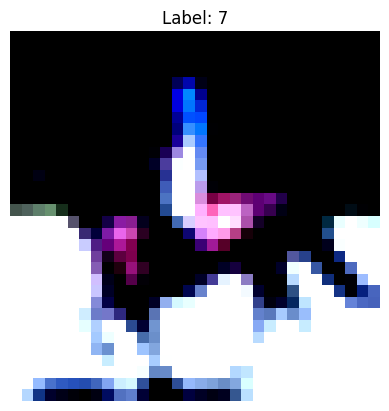

In [11]:
# Dataloader確認
for i, (images, labels) in enumerate(train_loader):
    # print(images.shape) # [B, C, H, W]
    # print(labels.shape) # [B]

    image_0 = images[0]
    label_0 = labels[0]

    # tensorをnumpyに変換し、チャンネル次元を削除
    # plt.imshow(image_0.squeeze(), cmap='gray') # for MNIST
    plt.imshow(image_0.permute(1, 2, 0)) # for CIFAR-10
    plt.title(f"Label: {label_0}")
    plt.axis('off')
    plt.show()
    break

## DenseNet-121

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


class DenseLayer(nn.Module):
    def __init__(
        self,
        in_channels,
        growth_rate, # 出力の次元の成長率
        drop_rate,
    ):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(in_channels) # チャンネルごとでバッチ正規化
        self.relu1 = nn.ReLU(inplace=True) # inplace=Trueによりメモリ節約
        self.conv1 = nn.Conv2d(in_channels, growth_rate * 4, kernel_size=1, bias=False) # 1*1 conv
        self.norm2 = nn.BatchNorm2d(growth_rate * 4)

        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(growth_rate * 4, growth_rate, kernel_size=3, padding=1, bias=False) # 3*3 conv
        self.dropout = nn.Dropout(p=drop_rate)

    def forward(self, x):
        x = torch.cat(x, 1) # チャンネル方向で連結 -> ResNetでは加算だった、全ての前の層のデータを利用
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.dropout(x)

        return x # 出力 -> この後連結され、特徴量次元が成長

class DenseBlock(nn.ModuleDict): # nn.ModuleDictを使うことで名前で管理できる
    def __init__(
        self,
        num_layers,
        in_channels,
        growth_rate,
        drop_rate,
    ):
        super().__init__()
        for i in range(num_layers):
            layer = DenseLayer(
                in_channels + i * growth_rate,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.add_module(f"denselayer{i + 1}", layer) # denselayer1, denselayer2, ...

    def forward(self, x0):
        x = [x0] # これまでの特徴マップを連結したリスト
        for name, layer in self.items():
            out = layer(x)
            x.append(out)

        return torch.cat(x, 1) # 出力を連結

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) # 1*1 conv
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # pooling, padding=False

    def forward(self, x):
        x = self.norm(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)

        return x

class DenseNet(nn.Module):
    def __init__(self,
                 growth_rate,
                 block_config,
                 input_channels = 3, # 白黒画像はチャンネル数1
                 drop_rate=0,
                 num_classes=10,
                 ):
        super().__init__()

        # エンコーダー
        self.input_features = nn.Sequential()
        self.features = nn.Sequential()
        self.gap_features = nn.Sequential()

        # 入力の畳み込み
        self.input_features.add_module("conv0", nn.Conv2d(input_channels, growth_rate * 2, kernel_size=7, stride=2, padding=3, bias=False)) # size=[H/2, W/2]
        self.input_features.add_module("norm0", nn.BatchNorm2d(growth_rate * 2))
        self.input_features.add_module("relu0", nn.ReLU(inplace=True))
        self.input_features.add_module("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) # max pooling, size=[H/4, W/4]

        # DenseBlock + Transition Layer
        # size=[H/4, W/4] -> [H/32, W/32]
        in_channels = growth_rate * 2
        # print(in_channels)
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=in_channels,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            self.features.add_module(f"denseblock{i + 1}", block)

            # 特徴量次元を更新
            in_channels += growth_rate * num_layers

            # 最後の Dense Block でない場合は、Transition Layer を追加
            if i != len(block_config) - 1:
                trans = TransitionLayer(in_channels=in_channels, out_channels=in_channels // 2)
                self.features.add_module(f"transition{i + 1}", trans)
                in_channels = in_channels // 2
                # print(i, in_channels)

            self.gap_features.add_module("norm5", nn.BatchNorm2d(in_channels))
            self.gap_features.add_module("relu5", nn.ReLU(inplace=True))
            self.gap_features.add_module("pool5", nn.AdaptiveAvgPool2d((1, 1))) # Global Average Pooling, size=[1, 1]

            self.classifier = nn.Linear(in_channels, num_classes)

            # 重みを初期化する。
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_features(x)
        x = self.features(x)
        x = self.gap_features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

## Train eval

In [44]:
from torch.optim.lr_scheduler import ExponentialLR
from torch import optim
from tqdm import tqdm
import os
import copy

# model
model = DenseNet(config.growth_rate, config.block_config)
model.to(config.device)

# loss function
criterion = F.cross_entropy

# optimizer
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# schedular
scheduler = ExponentialLR(optimizer, gamma=0.95)

# save path
os.makedirs("models", exist_ok=True)

64
0 128
1 256
2 512


In [ ]:
startEpoch = 0

# エポックごとの損失平均や正答率平均を保存
epoch_losses = []
epoch_accs = []
epoch_val_losses = []
epoch_val_accs = []
val_loss_best = float('inf')


# epoch loop
for epoch in range(config.num_epochs):
    model.train()
    # エポック内の損失平均や正答率平均を計算
    epoch_o_loss = []
    epoch_o_acc = []
    epoch_val_o_loss = []
    epoch_val_o_acc = []

    with tqdm(train_loader) as pbar:
        pbar.set_description(f'[エポック {epoch + 1}]')

        for x, y in pbar:
            # データをモデルと同じデバイスに転送
            x = x.to(config.device) # images [B, C, H, W]
            y = y.to(config.device) # labels [B]

            # パラメータの勾配をリセット
            optimizer.zero_grad()

            # 順伝播
            y_pred = model(x)

            # 学習データに対する損失と正確度を計算
            loss = criterion(y_pred, y)
            accuracy = (y_pred.argmax(dim=1) == \
                        y).float().mean()

            # 誤差逆伝播
            loss.backward()

            # パラメータの更新
            optimizer.step()

            # 損失を保存
            epoch_o_loss.append(loss.item()) # スケールはF.cross_entropy内で正規化されている
            epoch_o_acc.append(accuracy.item())
            pbar.set_postfix({
                'loss': torch.Tensor(epoch_o_loss).mean().item(),
                'accuracy': torch.Tensor(epoch_o_acc).mean().item()})

    with torch.no_grad():
        with tqdm(val_loader) as pbar:

            for x, y in pbar:
                # データをモデルと同じデバイスに転送
                x = x.to(config.device) # images [B, C, H, W]
                y = y.to(config.device) # labels [B]

                # 順伝播
                y_pred = model(x)

                # 学習データに対する損失と正確度を計算
                loss = criterion(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == \
                            y).float().mean()

                # 移動平均を計算して表示
                epoch_val_o_loss.append(loss.item())
                epoch_val_o_acc.append(accuracy.item())
                pbar.set_postfix({
                    'val_loss': torch.Tensor(epoch_val_o_loss).mean().item(),
                    'val_accuracy': torch.Tensor(epoch_val_o_acc).mean().item()})

    # 損失の保存
    epoch_loss = torch.Tensor(epoch_o_loss).mean().item()
    epoch_acc = torch.Tensor(epoch_o_acc).mean().item()
    epoch_val_loss = torch.Tensor(epoch_val_o_loss).mean().item()
    epoch_val_acc = torch.Tensor(epoch_val_o_acc).mean().item()

    epoch_losses.append(epoch_loss)
    epoch_accs.append(epoch_acc)
    epoch_val_losses.append(epoch_val_loss)
    epoch_val_accs.append(epoch_val_acc)

    print(f'検証　: loss = {epoch_val_loss:.3f}, '
            f'accuracy = {epoch_val_acc:.3f}')

    # より良い検証結果が得られた場合、モデルを記録
    if epoch_val_loss < val_loss_best:
        val_loss_best = epoch_val_loss
        model_best = copy.deepcopy(model.state_dict())

    # エポック終了時にスケジューラを更新
    scheduler.step()

    # モデルパラメータを保存
    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "best_model_dict": model_best,
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "epoch_losses": epoch_losses,
                "epoch_accs": epoch_accs,
                "epoch_val_losses": epoch_val_losses,
                "epoch_val_accs": epoch_val_accs,
                "best_loss": val_loss_best
                }, f"models/{epoch}_{best_loss}.pt")

100%|██████████| 625/625 [00:20<00:00, 30.84it/s, val_loss=1.97, val_accuracy=0.296]


検証　: loss = 1.972, accuracy = 0.296


100%|██████████| 625/625 [00:19<00:00, 31.89it/s, val_loss=1.83, val_accuracy=0.347]


検証　: loss = 1.827, accuracy = 0.347


100%|██████████| 625/625 [00:19<00:00, 31.36it/s, val_loss=1.74, val_accuracy=0.376]


検証　: loss = 1.738, accuracy = 0.376


100%|██████████| 625/625 [00:20<00:00, 31.21it/s, val_loss=1.68, val_accuracy=0.391]


検証　: loss = 1.679, accuracy = 0.391


[エポック 5]:  46%|████▌     | 1141/2500 [01:32<01:45, 12.83it/s, loss=1.69, accuracy=0.383]